In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from datetime import datetime, timedelta
from torch_geometric.nn import GATv2Conv, GATConv
from torch_geometric.utils import dense_to_sparse
from torch.distributions import Normal, Laplace, RelaxedOneHotCategorical
from torchdiffeq import odeint  # For continuous-time normalizing flows

from feature.scalers import ranged_scaler
from feature.engineering import *
from CARAT.model_utils import *
from CARAT.model import CausalGraphVAE
from CARAT.components import *
from utils.utils import set_seed, logger

# Torch settings
"""torch.use_deterministic_algorithms(False)
torch.backends.cudnn.benchmark = False
torch.autograd.profiler.profile(enabled=False)
torch.autograd.profiler.emit_nvtx(enabled=False)
torch.autograd.set_detect_anomaly(mode=False)

# Environment variables
os.environ['CUBLAS_WORKSPACE_CONFIG'] = '167772160'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = "1"""

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
data = []
with open('data/TEP/idv8/y.dat', 'r') as file:
    for line in file:
        columns = line.strip().split("\t")
        data.append([float(col.strip()) for col in columns])


In [2]:
vars = len(data[0])
col_names = []
for i in  range(0,vars):
    col_names.append('x_'+str(i+1))
    

In [3]:
import polars as pl
from feature.scalers import ranged_scaler
df = pl.DataFrame(data,schema=col_names)
for col in df.columns:
    df = df.with_columns(ranged_scaler(df[col]))

In [ ]:
df = make_stationary(df)

In [4]:
df=df.to_pandas()

In [5]:
#random dates, trivial for this exercise

start_date = '2023-03-01'  # Define the start date
date_range = pd.date_range(start=start_date, periods=df.shape[0])

In [6]:
n_lags = most_frequent(find_optimal_lags_for_dataframe(df))+1

In [7]:
df['time']=date_range

<Axes: xlabel='None', ylabel='x_26'>

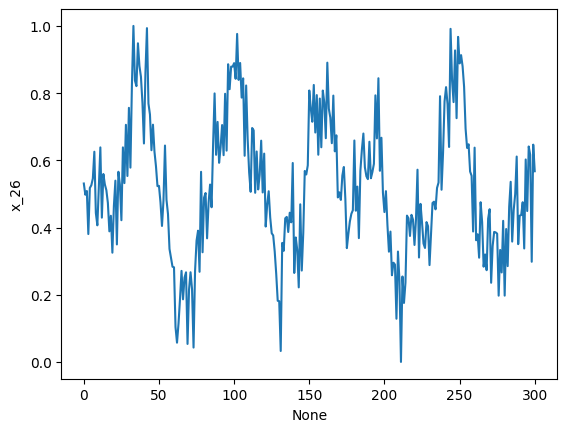

In [8]:
sns.lineplot(data=df,y='x_26',x=df.index)

<Axes: xlabel='None', ylabel='x_4'>

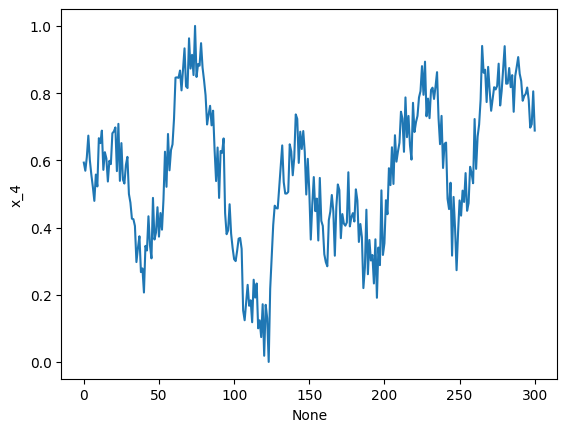

In [9]:
sns.lineplot(data=df,y='x_4',x=df.index)

In [10]:
df = df[['x_3', 'x_4','x_6','x_9','x_14','x_21','x_23','x_24','x_26','x_31','x_32']]

In [11]:
df.shape

(301, 11)

In [12]:
normal = df[100:]
bad = df[0:100]

In [13]:
df.columns

Index(['x_3', 'x_4', 'x_6', 'x_9', 'x_14', 'x_21', 'x_23', 'x_24', 'x_26',
       'x_31', 'x_32'],
      dtype='object')

In [14]:
try:
    df = df.drop('time',axis=1)
except:
    None

try:
    normal = normal.drop('time',axis=1)
except:
    None
try:
    bad = bad.drop('time',axis=1)
except:
    None

# Pretraining

In [15]:
import torch
import random
import numpy as np

# Define the seed value
seed = 42

# Set seed for PyTorch
torch.manual_seed(seed)

# Set seed for CUDA (if using GPUs)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set seed for Python's random module
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Ensure deterministic behavior for PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [24]:
TIME_STEPS = 5
BATCH_SIZE = 50
hidden_dim = 128
latent_dim = 8
edge_correct = 0
instantaneous_correct = 0
lagged_correct = 0
counterfactual_correct = 0 
rr_correct = 0
total_correct = 0
total_checked = 0
cols = df.columns.tolist()
for i in range(30):
    total_checked+=1

    dataset_bad = TimeSeriesDataset(df, device=device, time_steps=TIME_STEPS)
    dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize model and optimizer
    fine_tuned = CausalGraphVAE(input_dim=df.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=normal.shape[1], device=device,
                        time_steps=TIME_STEPS, prior_adj=None,instantaneous_weight=0.3).to(device)
    optimizer = torch.optim.AdamW(fine_tuned.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Train on nominal data
    # print("Pretraining on nominal data...")
    fine_tuned.train_model(dataloader_bad, optimizer, num_epochs=500, patience=60,BATCH_SIZE=BATCH_SIZE,rho_max=1.5,alpha_max=1.5)
    
    X_data = torch.empty(0,device=device)
    T_data = torch.empty(0,device=device)
    for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
        X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
        T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))
    
    causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_24',cols,non_causal_indices=[])
    
    edge_cause_1 = causes.sort_values(by='causes',ascending=False)[0:3].index[0]
    edge_cause_2 = causes.sort_values(by='causes',ascending=False)[0:3].index[1]
    edge_cause_3 = causes.sort_values(by='causes',ascending=False)[0:3].index[2]
    
    instant_cause_1 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[0]
    instant_cause_2 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[1]
    instant_cause_3 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[2]
    
    lag_cause_1 = causes.sort_values(by='lagged',ascending=False)[0:3].index[0]
    lag_cause_2 = causes.sort_values(by='lagged',ascending=False)[0:3].index[1]
    lag_cause_3 = causes.sort_values(by='lagged',ascending=False)[0:3].index[2]
    
    counterfactual_cause_1 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[0]
    counterfactual_cause_2 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[1]
    counterfactual_cause_3 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[2]
    
    rr_cause_1 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[0]
    rr_cause_2 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[1]
    rr_cause_3 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[2]
    
    total_score_cause_1=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[0]
    total_score_cause_2=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[1]
    total_score_cause_3=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[2]
    
    if (edge_cause_1 in ['x_26','x_4']) | (edge_cause_2 in ['x_26','x_4']) | (edge_cause_3 in ['x_26','x_4']):
        edge_correct+=1
    
    if (  total_score_cause_1 in ['x_26','x_4']) | (total_score_cause_2 in ['x_26','x_4']) | ( total_score_cause_3 in ['x_26','x_4']):
        total_correct+=1
    
    if (counterfactual_cause_1 in ['x_26','x_4']) | (counterfactual_cause_2 in ['x_26','x_4']) | (counterfactual_cause_3 in ['x_26','x_4']):
        counterfactual_correct+=1
    
    if (instant_cause_1 in ['x_26','x_4']) | (instant_cause_2 in ['x_26','x_4']) |( instant_cause_3 in ['x_26','x_4'] ):
        instantaneous_correct+=1
    
    if (lag_cause_1 in ['x_26','x_4']) | (lag_cause_2 in ['x_26','x_4'])  | (lag_cause_3 in ['x_26','x_4']):
        lagged_correct+=1
    
    if (rr_cause_1 in ['x_26','x_4']) | (rr_cause_2 in ['x_26','x_4']) | (rr_cause_3 in ['x_26','x_4']):
        rr_correct+=1
        
    total_accuracy = total_correct/total_checked* 100
    edge_accuracy = edge_correct/total_checked* 100
    cf_accuracy = counterfactual_correct/total_checked* 100
    instant_accuracy = instantaneous_correct/total_checked* 100
    lag_accuracy = lagged_correct/total_checked* 100
    rr_accuracy = rr_correct/total_checked* 100
    
    
    logger.info(f"Edge Accuracy = {edge_accuracy:.2f}, Instantaneous Accuracy = {instant_accuracy:.2f}, Lagged Accuracy = {lag_accuracy:.2f}, Counterfactual Accuracy = {cf_accuracy:.2f},  Blended Accuracy = {total_accuracy:.2f},  RR Accuracy = {rr_accuracy:.2f}  ") 
    


Epoch 1: Loss = 157898471093.3333
Recon Loss =334.3880, KL Loss = 0.5644, Sparsity Loss = 103.9994, Lagrangian Loss = 3476596736.0000
Epoch 51: Loss = 3326370837.3333
Recon Loss =60.1460, KL Loss = 0.6021, Sparsity Loss = 97.8054, Lagrangian Loss = 3150373120.0000
Epoch 101: Loss = 38944055482.6667
Recon Loss =54.5091, KL Loss = 0.2697, Sparsity Loss = 100.8678, Lagrangian Loss = 11826918400.0000
Epoch 151: Loss = 17389841280.0000
Recon Loss =74.9419, KL Loss = 0.1639, Sparsity Loss = 95.5772, Lagrangian Loss = 4300970496.0000
Epoch 201: Loss = 8067950661.3333
Recon Loss =58.3518, KL Loss = 0.1379, Sparsity Loss = 93.4825, Lagrangian Loss = 1724094080.0000


2025-03-20 15:27:41,163 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 0.00,  Blended Accuracy = 100.00,  RR Accuracy = 100.00  


Early stopping triggered. Last Epoch: 205
Recon Loss =62.9146, KL Loss = 0.1524, Sparsity Loss = 95.0479, Lagrangian Loss = 7559447040.0000
Epoch 1: Loss = 4728307655872.0000
Recon Loss =309.1864, KL Loss = 0.2990, Sparsity Loss = 110.2624, Lagrangian Loss = 3080733696.0000
Epoch 51: Loss = 958255105.3333
Recon Loss =45.3455, KL Loss = 0.5343, Sparsity Loss = 102.0865, Lagrangian Loss = 235720032.0000
Epoch 101: Loss = 819522325.3333
Recon Loss =38.6690, KL Loss = 0.2174, Sparsity Loss = 98.8622, Lagrangian Loss = 115621856.0000
Epoch 151: Loss = 223944228.6667
Recon Loss =40.8389, KL Loss = 0.1364, Sparsity Loss = 98.2402, Lagrangian Loss = 635279744.0000
Epoch 201: Loss = 400006837.3333
Recon Loss =42.9094, KL Loss = 0.0902, Sparsity Loss = 99.5431, Lagrangian Loss = 712739392.0000
Epoch 251: Loss = 196502237.1667
Recon Loss =43.4142, KL Loss = 0.0700, Sparsity Loss = 96.2775, Lagrangian Loss = 635722816.0000
Epoch 301: Loss = 690502942.6667
Recon Loss =40.3569, KL Loss = 0.0774, Spa

2025-03-20 15:28:30,300 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 0.00,  Blended Accuracy = 50.00,  RR Accuracy = 100.00  


Early stopping triggered. Last Epoch: 335
Recon Loss =40.2990, KL Loss = 0.0748, Sparsity Loss = 98.5614, Lagrangian Loss = 2572861952.0000
Epoch 1: Loss = 2937632981.3333
Recon Loss =335.9591, KL Loss = 0.2735, Sparsity Loss = 106.4691, Lagrangian Loss = 658497920.0000
Epoch 51: Loss = 38463416170.6667
Recon Loss =54.7827, KL Loss = 0.9035, Sparsity Loss = 98.8360, Lagrangian Loss = 6177923072.0000
Epoch 101: Loss = 1458853208.0000
Recon Loss =47.8144, KL Loss = 0.4419, Sparsity Loss = 92.0799, Lagrangian Loss = 1533275904.0000
Epoch 151: Loss = 5191551840.0000
Recon Loss =49.7034, KL Loss = 0.2728, Sparsity Loss = 92.5089, Lagrangian Loss = 1994735360.0000


2025-03-20 15:28:54,151 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 33.33,  Blended Accuracy = 66.67,  RR Accuracy = 66.67  


Early stopping triggered. Last Epoch: 160
Recon Loss =46.8765, KL Loss = 0.2952, Sparsity Loss = 92.3689, Lagrangian Loss = 4240475136.0000
Epoch 1: Loss = 30727808426.6667
Recon Loss =508.5582, KL Loss = 0.2810, Sparsity Loss = 108.7049, Lagrangian Loss = 5200548864.0000
Epoch 51: Loss = 12913477632.0000
Recon Loss =57.8166, KL Loss = 0.5041, Sparsity Loss = 101.2085, Lagrangian Loss = 3712197120.0000


2025-03-20 15:29:05,293 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 100.00, Counterfactual Accuracy = 25.00,  Blended Accuracy = 75.00,  RR Accuracy = 50.00  


Early stopping triggered. Last Epoch: 71
Recon Loss =57.4850, KL Loss = 0.3670, Sparsity Loss = 94.5847, Lagrangian Loss = 18685167616.0000
Epoch 1: Loss = 2390316464.0000
Recon Loss =322.8713, KL Loss = 0.3119, Sparsity Loss = 105.5412, Lagrangian Loss = 2713120512.0000
Epoch 51: Loss = 90584667477.3333
Recon Loss =78.2193, KL Loss = 0.4531, Sparsity Loss = 98.3525, Lagrangian Loss = 12914325504.0000


2025-03-20 15:29:19,561 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 80.00, Counterfactual Accuracy = 20.00,  Blended Accuracy = 80.00,  RR Accuracy = 40.00  


Early stopping triggered. Last Epoch: 93
Recon Loss =62.5541, KL Loss = 0.3048, Sparsity Loss = 100.9694, Lagrangian Loss = 4058578176.0000
Epoch 1: Loss = 30267396202.6667
Recon Loss =317.4831, KL Loss = 0.2268, Sparsity Loss = 109.6663, Lagrangian Loss = 6166006272.0000
Epoch 51: Loss = 11676248978.6667
Recon Loss =49.6322, KL Loss = 0.5301, Sparsity Loss = 101.1706, Lagrangian Loss = 15840138240.0000


2025-03-20 15:29:29,030 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 83.33, Counterfactual Accuracy = 33.33,  Blended Accuracy = 66.67,  RR Accuracy = 50.00  


Early stopping triggered. Last Epoch: 61
Recon Loss =53.4455, KL Loss = 0.4265, Sparsity Loss = 98.9570, Lagrangian Loss = 495644320.0000
Epoch 1: Loss = 2686912362.6667
Recon Loss =363.0244, KL Loss = 0.3213, Sparsity Loss = 104.9373, Lagrangian Loss = 1101803136.0000
Epoch 51: Loss = 6846404341.3333
Recon Loss =75.8344, KL Loss = 0.7375, Sparsity Loss = 98.2797, Lagrangian Loss = 635598464.0000
Epoch 101: Loss = 4710119445.3333
Recon Loss =85.0448, KL Loss = 0.2102, Sparsity Loss = 99.9235, Lagrangian Loss = 1509139072.0000


2025-03-20 15:29:46,488 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 85.71, Lagged Accuracy = 85.71, Counterfactual Accuracy = 42.86,  Blended Accuracy = 57.14,  RR Accuracy = 57.14  


Early stopping triggered. Last Epoch: 119
Recon Loss =86.2989, KL Loss = 0.2381, Sparsity Loss = 95.4968, Lagrangian Loss = 306665024.0000
Epoch 1: Loss = 2623493662560.0000
Recon Loss =388.6170, KL Loss = 0.5797, Sparsity Loss = 110.9621, Lagrangian Loss = 68598358016.0000
Epoch 51: Loss = 458887773.3333
Recon Loss =53.3029, KL Loss = 0.7834, Sparsity Loss = 102.5634, Lagrangian Loss = 286153824.0000
Epoch 101: Loss = 368362573.0000
Recon Loss =43.1373, KL Loss = 0.3020, Sparsity Loss = 100.5889, Lagrangian Loss = 194094432.0000
Epoch 151: Loss = 768332256.0000
Recon Loss =40.8404, KL Loss = 0.1562, Sparsity Loss = 99.0845, Lagrangian Loss = 169733408.0000


2025-03-20 15:30:17,200 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 75.00, Lagged Accuracy = 87.50, Counterfactual Accuracy = 37.50,  Blended Accuracy = 50.00,  RR Accuracy = 50.00  


Early stopping triggered. Last Epoch: 199
Recon Loss =41.3507, KL Loss = 0.1080, Sparsity Loss = 93.7137, Lagrangian Loss = 23541320.0000
Epoch 1: Loss = 7324993962.6667
Recon Loss =314.4272, KL Loss = 0.2915, Sparsity Loss = 107.6688, Lagrangian Loss = 4655272960.0000
Epoch 51: Loss = 6742970250.6667
Recon Loss =96.8284, KL Loss = 0.8127, Sparsity Loss = 100.5964, Lagrangian Loss = 14602229760.0000


2025-03-20 15:30:26,998 INFO -- Edge Accuracy = 88.89, Instantaneous Accuracy = 66.67, Lagged Accuracy = 77.78, Counterfactual Accuracy = 44.44,  Blended Accuracy = 44.44,  RR Accuracy = 44.44  


Early stopping triggered. Last Epoch: 62
Recon Loss =81.3632, KL Loss = 0.6392, Sparsity Loss = 102.3878, Lagrangian Loss = 14955521024.0000
Epoch 1: Loss = 335580612608.0000
Recon Loss =428.4468, KL Loss = 0.3684, Sparsity Loss = 110.1633, Lagrangian Loss = 8397059584.0000
Epoch 51: Loss = 1603590797.3333
Recon Loss =53.1406, KL Loss = 0.4923, Sparsity Loss = 103.3953, Lagrangian Loss = 900223936.0000
Epoch 101: Loss = 61693004672.0000
Recon Loss =50.3802, KL Loss = 0.2152, Sparsity Loss = 104.1310, Lagrangian Loss = 61692489728.0000


2025-03-20 15:30:45,094 INFO -- Edge Accuracy = 90.00, Instantaneous Accuracy = 60.00, Lagged Accuracy = 80.00, Counterfactual Accuracy = 40.00,  Blended Accuracy = 40.00,  RR Accuracy = 50.00  


Early stopping triggered. Last Epoch: 119
Recon Loss =54.5931, KL Loss = 0.1835, Sparsity Loss = 99.2775, Lagrangian Loss = 5355238400.0000
Epoch 1: Loss = 903024955498.6666
Recon Loss =302.2363, KL Loss = 0.3273, Sparsity Loss = 108.5350, Lagrangian Loss = 2961630720.0000
Epoch 51: Loss = 107672737.3333
Recon Loss =45.6719, KL Loss = 0.5244, Sparsity Loss = 102.6250, Lagrangian Loss = 226540704.0000
Epoch 101: Loss = 51467205.8333
Recon Loss =37.8721, KL Loss = 0.2265, Sparsity Loss = 98.1771, Lagrangian Loss = 75840864.0000


2025-03-20 15:31:05,504 INFO -- Edge Accuracy = 90.91, Instantaneous Accuracy = 63.64, Lagged Accuracy = 81.82, Counterfactual Accuracy = 45.45,  Blended Accuracy = 36.36,  RR Accuracy = 45.45  


Early stopping triggered. Last Epoch: 139
Recon Loss =42.3397, KL Loss = 0.1521, Sparsity Loss = 97.5421, Lagrangian Loss = 37549312.0000
Epoch 1: Loss = 125425055808.0000
Recon Loss =438.4080, KL Loss = 0.3330, Sparsity Loss = 105.4369, Lagrangian Loss = 1945653120.0000
Epoch 51: Loss = 345605386.0000
Recon Loss =45.5846, KL Loss = 0.6521, Sparsity Loss = 97.8445, Lagrangian Loss = 324797120.0000


2025-03-20 15:31:17,190 INFO -- Edge Accuracy = 91.67, Instantaneous Accuracy = 66.67, Lagged Accuracy = 83.33, Counterfactual Accuracy = 50.00,  Blended Accuracy = 33.33,  RR Accuracy = 50.00  


Early stopping triggered. Last Epoch: 76
Recon Loss =77.2433, KL Loss = 0.4861, Sparsity Loss = 102.9057, Lagrangian Loss = 2557605120.0000
Epoch 1: Loss = 31651845440.0000
Recon Loss =362.4441, KL Loss = 0.1847, Sparsity Loss = 106.6020, Lagrangian Loss = 26213230592.0000
Epoch 51: Loss = 41307034154.6667
Recon Loss =67.6437, KL Loss = 0.8014, Sparsity Loss = 98.3226, Lagrangian Loss = 3785063424.0000


2025-03-20 15:31:27,653 INFO -- Edge Accuracy = 92.31, Instantaneous Accuracy = 61.54, Lagged Accuracy = 84.62, Counterfactual Accuracy = 46.15,  Blended Accuracy = 30.77,  RR Accuracy = 53.85  


Early stopping triggered. Last Epoch: 67
Recon Loss =61.0285, KL Loss = 0.5720, Sparsity Loss = 101.3511, Lagrangian Loss = 2580304896.0000
Epoch 1: Loss = 25069904890.6667
Recon Loss =366.0524, KL Loss = 0.2840, Sparsity Loss = 107.7120, Lagrangian Loss = 18581962752.0000
Epoch 51: Loss = 34862873514.6667
Recon Loss =79.3369, KL Loss = 0.4902, Sparsity Loss = 99.8423, Lagrangian Loss = 6725180416.0000


2025-03-20 15:31:38,036 INFO -- Edge Accuracy = 92.86, Instantaneous Accuracy = 57.14, Lagged Accuracy = 85.71, Counterfactual Accuracy = 50.00,  Blended Accuracy = 35.71,  RR Accuracy = 57.14  


Early stopping triggered. Last Epoch: 70
Recon Loss =77.0489, KL Loss = 0.3036, Sparsity Loss = 97.2190, Lagrangian Loss = 1771654272.0000
Epoch 1: Loss = 56760410677.3333
Recon Loss =346.2389, KL Loss = 0.3360, Sparsity Loss = 108.0271, Lagrangian Loss = 1555218304.0000
Epoch 51: Loss = 8481693632.0000
Recon Loss =64.2331, KL Loss = 0.5451, Sparsity Loss = 102.9152, Lagrangian Loss = 15519133696.0000


2025-03-20 15:31:51,007 INFO -- Edge Accuracy = 86.67, Instantaneous Accuracy = 60.00, Lagged Accuracy = 86.67, Counterfactual Accuracy = 53.33,  Blended Accuracy = 33.33,  RR Accuracy = 53.33  


Early stopping triggered. Last Epoch: 83
Recon Loss =70.5353, KL Loss = 0.2866, Sparsity Loss = 98.1434, Lagrangian Loss = 2117039744.0000
Epoch 1: Loss = 2305382474.6667
Recon Loss =438.2728, KL Loss = 0.4055, Sparsity Loss = 106.3988, Lagrangian Loss = 1418826624.0000
Epoch 51: Loss = 5545279968.0000
Recon Loss =60.9430, KL Loss = 0.6729, Sparsity Loss = 99.7974, Lagrangian Loss = 4449366016.0000


2025-03-20 15:32:00,066 INFO -- Edge Accuracy = 81.25, Instantaneous Accuracy = 56.25, Lagged Accuracy = 81.25, Counterfactual Accuracy = 56.25,  Blended Accuracy = 31.25,  RR Accuracy = 50.00  


Early stopping triggered. Last Epoch: 60
Recon Loss =60.3516, KL Loss = 0.4696, Sparsity Loss = 98.2414, Lagrangian Loss = 7203195904.0000
Epoch 1: Loss = 4129403052.6667
Recon Loss =289.0062, KL Loss = 0.1294, Sparsity Loss = 104.7990, Lagrangian Loss = 406560192.0000
Epoch 51: Loss = 4207620506.6667
Recon Loss =59.9115, KL Loss = 0.4243, Sparsity Loss = 98.4254, Lagrangian Loss = 2428608512.0000


2025-03-20 15:32:10,160 INFO -- Edge Accuracy = 76.47, Instantaneous Accuracy = 52.94, Lagged Accuracy = 76.47, Counterfactual Accuracy = 52.94,  Blended Accuracy = 29.41,  RR Accuracy = 47.06  


Early stopping triggered. Last Epoch: 65
Recon Loss =57.0751, KL Loss = 0.3358, Sparsity Loss = 94.8872, Lagrangian Loss = 1239015552.0000
Epoch 1: Loss = 2899544421.3333
Recon Loss =425.7968, KL Loss = 0.2406, Sparsity Loss = 106.8427, Lagrangian Loss = 2229658880.0000
Epoch 51: Loss = 14216879573.3333
Recon Loss =89.1672, KL Loss = 0.4833, Sparsity Loss = 95.5713, Lagrangian Loss = 8300562432.0000
Epoch 101: Loss = 12327709354.6667
Recon Loss =97.3561, KL Loss = 0.2624, Sparsity Loss = 97.1408, Lagrangian Loss = 33644754944.0000


2025-03-20 15:32:26,307 INFO -- Edge Accuracy = 77.78, Instantaneous Accuracy = 55.56, Lagged Accuracy = 77.78, Counterfactual Accuracy = 55.56,  Blended Accuracy = 33.33,  RR Accuracy = 50.00  


Early stopping triggered. Last Epoch: 111
Recon Loss =89.7082, KL Loss = 0.1921, Sparsity Loss = 95.7883, Lagrangian Loss = 11390917632.0000
Epoch 1: Loss = 2102785772373.3333
Recon Loss =341.8360, KL Loss = 0.3337, Sparsity Loss = 110.2793, Lagrangian Loss = 31387342848.0000
Epoch 51: Loss = 750250274.6667
Recon Loss =46.3801, KL Loss = 0.7586, Sparsity Loss = 99.3080, Lagrangian Loss = 226225088.0000
Epoch 101: Loss = 423995394.6667
Recon Loss =38.5018, KL Loss = 0.3155, Sparsity Loss = 98.8417, Lagrangian Loss = 194357040.0000
Epoch 151: Loss = 258271092.0000
Recon Loss =40.2067, KL Loss = 0.2030, Sparsity Loss = 98.6785, Lagrangian Loss = 464058496.0000
Epoch 201: Loss = 129736032.0000
Recon Loss =36.8479, KL Loss = 0.1396, Sparsity Loss = 94.6075, Lagrangian Loss = 38868164.0000
Epoch 251: Loss = 106787993.0000
Recon Loss =37.7258, KL Loss = 0.0912, Sparsity Loss = 94.3766, Lagrangian Loss = 217779840.0000


2025-03-20 15:33:09,209 INFO -- Edge Accuracy = 78.95, Instantaneous Accuracy = 52.63, Lagged Accuracy = 78.95, Counterfactual Accuracy = 52.63,  Blended Accuracy = 31.58,  RR Accuracy = 52.63  


Early stopping triggered. Last Epoch: 289
Recon Loss =33.4214, KL Loss = 0.0700, Sparsity Loss = 96.2947, Lagrangian Loss = 157255248.0000
Epoch 1: Loss = 195173449536.0000
Recon Loss =325.5978, KL Loss = 0.2783, Sparsity Loss = 103.0135, Lagrangian Loss = 15362251776.0000
Epoch 51: Loss = 8745792554.6667
Recon Loss =60.1106, KL Loss = 0.7158, Sparsity Loss = 103.9451, Lagrangian Loss = 24855025664.0000
Epoch 101: Loss = 11210039840.0000
Recon Loss =57.0099, KL Loss = 0.3718, Sparsity Loss = 100.7540, Lagrangian Loss = 45147684864.0000


2025-03-20 15:33:27,804 INFO -- Edge Accuracy = 80.00, Instantaneous Accuracy = 50.00, Lagged Accuracy = 80.00, Counterfactual Accuracy = 55.00,  Blended Accuracy = 35.00,  RR Accuracy = 55.00  


Early stopping triggered. Last Epoch: 127
Recon Loss =63.5727, KL Loss = 0.2811, Sparsity Loss = 104.9286, Lagrangian Loss = 39897001984.0000
Epoch 1: Loss = 49975454720.0000
Recon Loss =308.2968, KL Loss = 0.3614, Sparsity Loss = 104.2676, Lagrangian Loss = 54410788864.0000
Epoch 51: Loss = 10634642858.6667
Recon Loss =52.9430, KL Loss = 0.5382, Sparsity Loss = 105.2923, Lagrangian Loss = 28235153408.0000


2025-03-20 15:33:42,339 INFO -- Edge Accuracy = 80.95, Instantaneous Accuracy = 52.38, Lagged Accuracy = 80.95, Counterfactual Accuracy = 52.38,  Blended Accuracy = 38.10,  RR Accuracy = 52.38  


Early stopping triggered. Last Epoch: 94
Recon Loss =56.3036, KL Loss = 0.2515, Sparsity Loss = 100.5944, Lagrangian Loss = 23388721152.0000
Epoch 1: Loss = 42700819168.0000
Recon Loss =342.6936, KL Loss = 0.2675, Sparsity Loss = 108.4735, Lagrangian Loss = 3098947584.0000
Epoch 51: Loss = 11479122229.3333
Recon Loss =53.8300, KL Loss = 0.4480, Sparsity Loss = 100.3270, Lagrangian Loss = 12937764864.0000


2025-03-20 15:33:52,642 INFO -- Edge Accuracy = 81.82, Instantaneous Accuracy = 54.55, Lagged Accuracy = 81.82, Counterfactual Accuracy = 54.55,  Blended Accuracy = 40.91,  RR Accuracy = 54.55  


Early stopping triggered. Last Epoch: 66
Recon Loss =72.9112, KL Loss = 0.4008, Sparsity Loss = 100.5940, Lagrangian Loss = 2416161280.0000
Epoch 1: Loss = 1739578952714.6667
Recon Loss =370.3321, KL Loss = 0.2975, Sparsity Loss = 117.2912, Lagrangian Loss = 8462982447104.0000
Epoch 51: Loss = 5353136757.3333
Recon Loss =43.5905, KL Loss = 0.4487, Sparsity Loss = 103.4543, Lagrangian Loss = 3103627008.0000
Epoch 101: Loss = 14384774186.6667
Recon Loss =45.2257, KL Loss = 0.1590, Sparsity Loss = 104.4047, Lagrangian Loss = 2377507840.0000


2025-03-20 15:34:14,833 INFO -- Edge Accuracy = 82.61, Instantaneous Accuracy = 56.52, Lagged Accuracy = 82.61, Counterfactual Accuracy = 56.52,  Blended Accuracy = 43.48,  RR Accuracy = 52.17  


Early stopping triggered. Last Epoch: 147
Recon Loss =44.3428, KL Loss = 0.1429, Sparsity Loss = 99.6681, Lagrangian Loss = 9048383488.0000
Epoch 1: Loss = 1347543877930.6667
Recon Loss =393.0651, KL Loss = 0.2536, Sparsity Loss = 114.3688, Lagrangian Loss = 161736933376.0000
Epoch 51: Loss = 1126036430.6667
Recon Loss =49.4059, KL Loss = 0.5056, Sparsity Loss = 104.0502, Lagrangian Loss = 2639199744.0000
Epoch 101: Loss = 290347767.3333
Recon Loss =43.4466, KL Loss = 0.2200, Sparsity Loss = 100.3989, Lagrangian Loss = 770292992.0000


2025-03-20 15:34:35,865 INFO -- Edge Accuracy = 83.33, Instantaneous Accuracy = 58.33, Lagged Accuracy = 83.33, Counterfactual Accuracy = 58.33,  Blended Accuracy = 45.83,  RR Accuracy = 54.17  


Early stopping triggered. Last Epoch: 146
Recon Loss =47.9778, KL Loss = 0.1345, Sparsity Loss = 103.7310, Lagrangian Loss = 400979904.0000
Epoch 1: Loss = 6460324017130.6670
Recon Loss =400.4214, KL Loss = 0.2957, Sparsity Loss = 111.3435, Lagrangian Loss = 295503462400.0000
Epoch 51: Loss = 20279838629.3333
Recon Loss =48.6084, KL Loss = 0.3428, Sparsity Loss = 98.2641, Lagrangian Loss = 6019086336.0000
Epoch 101: Loss = 11413032298.6667
Recon Loss =45.2211, KL Loss = 0.1663, Sparsity Loss = 95.5823, Lagrangian Loss = 26106923008.0000


2025-03-20 15:34:55,782 INFO -- Edge Accuracy = 80.00, Instantaneous Accuracy = 56.00, Lagged Accuracy = 80.00, Counterfactual Accuracy = 60.00,  Blended Accuracy = 44.00,  RR Accuracy = 52.00  


Early stopping triggered. Last Epoch: 130
Recon Loss =43.6847, KL Loss = 0.1060, Sparsity Loss = 98.9201, Lagrangian Loss = 60210843648.0000
Epoch 1: Loss = 45436173685.3333
Recon Loss =328.6682, KL Loss = 0.2242, Sparsity Loss = 105.2419, Lagrangian Loss = 15380883456.0000
Epoch 51: Loss = 1016453162.6667
Recon Loss =48.0270, KL Loss = 0.3852, Sparsity Loss = 99.9643, Lagrangian Loss = 99384320.0000
Epoch 101: Loss = 143440174.6667
Recon Loss =45.6408, KL Loss = 0.1803, Sparsity Loss = 93.9512, Lagrangian Loss = 182213776.0000


2025-03-20 15:35:15,345 INFO -- Edge Accuracy = 80.77, Instantaneous Accuracy = 57.69, Lagged Accuracy = 80.77, Counterfactual Accuracy = 57.69,  Blended Accuracy = 42.31,  RR Accuracy = 53.85  


Early stopping triggered. Last Epoch: 128
Recon Loss =45.1208, KL Loss = 0.1447, Sparsity Loss = 97.1204, Lagrangian Loss = 70604832.0000
Epoch 1: Loss = 60535771658.6667
Recon Loss =433.0234, KL Loss = 0.3694, Sparsity Loss = 113.1554, Lagrangian Loss = 221856088064.0000
Epoch 51: Loss = 2231160466.6667
Recon Loss =66.2132, KL Loss = 0.7916, Sparsity Loss = 101.3781, Lagrangian Loss = 394133376.0000
Epoch 101: Loss = 264605979.3333
Recon Loss =64.5065, KL Loss = 0.3506, Sparsity Loss = 100.6194, Lagrangian Loss = 1148526592.0000
Epoch 151: Loss = 168382222.6667
Recon Loss =60.3931, KL Loss = 0.1912, Sparsity Loss = 98.6106, Lagrangian Loss = 155519200.0000
Epoch 201: Loss = 208119229.3333
Recon Loss =63.9300, KL Loss = 0.1221, Sparsity Loss = 96.8953, Lagrangian Loss = 468633696.0000


2025-03-20 15:35:48,809 INFO -- Edge Accuracy = 81.48, Instantaneous Accuracy = 55.56, Lagged Accuracy = 81.48, Counterfactual Accuracy = 59.26,  Blended Accuracy = 44.44,  RR Accuracy = 55.56  


Early stopping triggered. Last Epoch: 220
Recon Loss =68.4988, KL Loss = 0.1183, Sparsity Loss = 93.8666, Lagrangian Loss = 460625760.0000
Epoch 1: Loss = 92028599776.0000
Recon Loss =348.8429, KL Loss = 0.2641, Sparsity Loss = 105.6632, Lagrangian Loss = 955449408.0000
Epoch 51: Loss = 76262985056.0000
Recon Loss =50.9878, KL Loss = 0.6224, Sparsity Loss = 97.7589, Lagrangian Loss = 417426592.0000


2025-03-20 15:36:00,357 INFO -- Edge Accuracy = 82.14, Instantaneous Accuracy = 57.14, Lagged Accuracy = 78.57, Counterfactual Accuracy = 57.14,  Blended Accuracy = 46.43,  RR Accuracy = 53.57  


Early stopping triggered. Last Epoch: 73
Recon Loss =51.4922, KL Loss = 0.4838, Sparsity Loss = 97.0769, Lagrangian Loss = 2857967104.0000
Epoch 1: Loss = 16120458400.0000
Recon Loss =318.6052, KL Loss = 0.5941, Sparsity Loss = 104.3736, Lagrangian Loss = 433903552.0000
Epoch 51: Loss = 18099227498.6667
Recon Loss =67.4541, KL Loss = 1.0428, Sparsity Loss = 101.8464, Lagrangian Loss = 47933849600.0000


2025-03-20 15:36:12,432 INFO -- Edge Accuracy = 82.76, Instantaneous Accuracy = 55.17, Lagged Accuracy = 79.31, Counterfactual Accuracy = 58.62,  Blended Accuracy = 44.83,  RR Accuracy = 55.17  


Early stopping triggered. Last Epoch: 79
Recon Loss =50.8560, KL Loss = 0.5883, Sparsity Loss = 99.5007, Lagrangian Loss = 1420075776.0000
Epoch 1: Loss = 725484063232.0000
Recon Loss =411.2511, KL Loss = 0.2817, Sparsity Loss = 108.8640, Lagrangian Loss = 264075460608.0000
Epoch 51: Loss = 3614824032.0000
Recon Loss =46.3379, KL Loss = 0.5335, Sparsity Loss = 98.6358, Lagrangian Loss = 4199051776.0000


2025-03-20 15:36:22,536 INFO -- Edge Accuracy = 80.00, Instantaneous Accuracy = 56.67, Lagged Accuracy = 76.67, Counterfactual Accuracy = 56.67,  Blended Accuracy = 46.67,  RR Accuracy = 53.33  


Early stopping triggered. Last Epoch: 62
Recon Loss =45.2126, KL Loss = 0.4442, Sparsity Loss = 99.5059, Lagrangian Loss = 2922372352.0000
